In [40]:
import numpy as np
import pandas as pd
import tensorflow as tf 
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Model 
from tensorflow.keras.layers import Conv2D, concatenate, Activation, MaxPooling2D, UpSampling2D, Input, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
import cv2
import matplotlib.pyplot as plt
import random
import os

In [41]:
image_path = '/Users/nouf/Desktop/archive/dataA/dataA/CameraRGB/'
mask_path = '/Users/nouf/Desktop/archive/dataA/dataA/CameraSeg/'
image_list = os.listdir(image_path)
mask_list = os.listdir(mask_path)
image_list = [image_path+i for i in image_list]
mask_list = [mask_path+i for i in mask_list]

In [42]:
X = image_list
Y = mask_list

In [43]:
X_train, X_val, Y_train, Y_val = train_test_split(X, Y, test_size = 0.2)
X_val, X_test, Y_val, Y_test = train_test_split(X_val, Y_val, test_size = 0.2)

In [44]:
def read_imageMask(image_path, mask_path):
    
    img = tf.io.read_file(image_path)
    img = tf.image.decode_png(img, channels=3)
    img = tf.image.convert_image_dtype(img, tf.float32)
    img = tf.image.resize(img, (256, 256), method='nearest')
    
    mask = tf.io.read_file(mask_path)
    mask = tf.image.decode_png(mask, channels=3)
    mask = tf.math.reduce_max(mask, axis=-1, keepdims=True)
    mask = tf.image.resize(mask, (256, 256), method='nearest')
    
    return img, mask

In [45]:
def data_generator(image_paths, mask_paths, batch_size):
    images = tf.constant(image_paths)
    masks = tf.constant(mask_paths)
    dataset = tf.data.Dataset.from_tensor_slices((images, masks))
    dataset = dataset.map(read_imageMask, num_parallel_calls=tf.data.experimental.AUTOTUNE)
    dataset = dataset.cache().shuffle(500).batch(batch_size)
    
    return dataset

In [46]:
train_generator = data_generator(X_train, Y_train, 32)
val_generator = data_generator(X_val, Y_val, 32)
test_generator = data_generator(X_test, Y_test, 32)

In [220]:
test_generator

<BatchDataset element_spec=(TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 256, 256, 1), dtype=tf.uint8, name=None))>

In [91]:
from keras.applications import vgg16

In [92]:
input_shape = (500, 500, 3)
VGG16_weight = "/Users/nouf/Desktop/vgg16_weights_tf_dim_ordering_tf_kernels_notop.h5"
VGG16 = vgg16.VGG16(include_top=False, weights=VGG16_weight, input_shape=input_shape)
print('Model loaded.')

Model loaded.


In [93]:
output_ = VGG16.output
output_

<KerasTensor: shape=(None, 15, 15, 512) dtype=float32 (created by layer 'block5_pool')>

In [94]:
set_trainable = False
for layer in VGG16.layers:
    if layer.name in ['block1_conv1']:
        set_trainable = True
    if layer.name in ['block1_pool','block2_pool','block3_pool','block4_pool','block5_pool']:
        layer.trainable = False

In [95]:
vgg_model = Model(VGG16.input, output_)
layers = [(layer, layer.name, layer.trainable) for layer in vgg_model.layers]
pd.DataFrame(layers, columns=['Layer Type', 'Layer Name', 'Layer Trainable'])

,Layer Type,Layer Name,Layer Trainable
0,<keras.engine.input_layer.InputLayer object at...,input_14,True
1,<keras.layers.convolutional.Conv2D object at 0...,block1_conv1,True
2,<keras.layers.convolutional.Conv2D object at 0...,block1_conv2,True
3,<keras.layers.pooling.MaxPooling2D object at 0...,block1_pool,False
4,<keras.layers.convolutional.Conv2D object at 0...,block2_conv1,True
5,<keras.layers.convolutional.Conv2D object at 0...,block2_conv2,True
6,<keras.layers.pooling.MaxPooling2D object at 0...,block2_pool,False
7,<keras.layers.convolutional.Conv2D object at 0...,block3_conv1,True
8,<keras.layers.convolutional.Conv2D object at 0...,block3_conv2,True
9,<keras.layers.convolutional.Conv2D object at 0...,block3_conv3,True


In [96]:
vgg_model.summary()

Model: "model_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_14 (InputLayer)       [(None, 500, 500, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 500, 500, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 500, 500, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 250, 250, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 250, 250, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 250, 250, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 125, 125, 128)     0  

In [98]:
from keras import backend as K

In [225]:
K.clear_session()
def ModelEnhancer():
    input_shape = (256, 256, 3)
    VGG16_weight = "/Users/nouf/Desktop/vgg16_weights_tf_dim_ordering_tf_kernels_notop.h5"
    VGG16 = vgg16.VGG16(include_top=False, weights=VGG16_weight, input_shape=input_shape)
    last_layer = VGG16.output
    
    set_trainable = False
    for layer in VGG16.layers:
        if layer.name in ['block1_conv1']:
            set_trainable = True
        if layer.name in ['block1_pool','block2_pool','block3_pool','block4_pool','block5_pool']:
            layer.trainable = False
   
    up6 = Conv2D(512, 2, activation='relu', kernel_initializer='he_normal', padding='same')(UpSampling2D(size=(2,2))(last_layer))
    up6 = tf.image.resize(up6, [16, 16])
    merge6 = concatenate([up6, VGG16.get_layer("block5_conv3").output], axis = 3)
    conv6 = Conv2D(512, 3, activation='relu', kernel_initializer='he_normal', padding='same')(merge6)
    conv6 = Conv2D(512, 3, activation='relu', kernel_initializer='he_normal', padding='same')(conv6)
    
    up7 = Conv2D(256, 2, activation='relu', kernel_initializer='he_normal', padding='same')(UpSampling2D(size=(2,2))(conv6))
    merge7 = concatenate([up7, VGG16.get_layer("block4_conv3").output], axis = 3)
    conv7 = Conv2D(256, 3, activation='relu', kernel_initializer='he_normal', padding='same')(merge7)
    conv7 = Conv2D(256, 3, activation='relu', kernel_initializer='he_normal', padding='same')(conv7)
    
    up8 = Conv2D(128, 2, activation='relu', kernel_initializer='he_normal', padding='same')(UpSampling2D(size=(2,2))(conv7))
    up8 = tf.image.resize(up8, [128, 128])
    merge8 = concatenate([up8, VGG16.get_layer("block2_conv2").output], axis = 3)
    conv8 = Conv2D(128, 3, activation='relu', kernel_initializer='he_normal', padding='same')(merge8)
    conv8 = Conv2D(128, 3, activation='relu', kernel_initializer='he_normal', padding='same')(conv8)
    
    up9 = Conv2D(64, 2, activation='relu', kernel_initializer='he_normal', padding='same')(UpSampling2D(size=(2,2))(conv8)) 
    merge9 = concatenate([up9, VGG16.get_layer("block1_conv2").output], axis = 3)
    conv9 = Conv2D(64, 3, activation='relu', kernel_initializer='he_normal', padding='same')(merge9)
    conv9 = Conv2D(64, 3, activation='relu', kernel_initializer='he_normal', padding='same')(conv9)
    
    conv10 = Conv2D(13, (1, 1), padding='same', activation='softmax')(conv9)
    
    model = Model(VGG16.input, conv10)
    
    return model

In [226]:
model = ModelEnhancer()
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 block1_conv1 (Conv2D)          (None, 256, 256, 64  1792        ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 block1_conv2 (Conv2D)          (None, 256, 256, 64  36928       ['block1_conv1[0][0]']           
                                )                                                             

                                                                                                  
 conv2d_8 (Conv2D)              (None, 128, 128, 12  147584      ['conv2d_7[0][0]']               
                                8)                                                                
                                                                                                  
 up_sampling2d_3 (UpSampling2D)  (None, 256, 256, 12  0          ['conv2d_8[0][0]']               
                                8)                                                                
                                                                                                  
 conv2d_9 (Conv2D)              (None, 256, 256, 64  32832       ['up_sampling2d_3[0][0]']        
                                )                                                                 
                                                                                                  
 concatena

In [237]:
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])


earlystopping = EarlyStopping(monitor='val_loss', patience= 5)

In [238]:
history = model.fit(train_generator, validation_data=val_generator,epochs=25,
                    verbose = 1, batch_size=16,
                    callbacks=[earlystopping])

Epoch 1/25
25/25 [==============================] - 1689s 68s/step - loss: 1.7477 - accuracy: 0.5575 - val_loss: 1.1537 - val_accuracy: 0.6298
Epoch 2/25
25/25 [==============================] - 1632s 66s/step - loss: 0.9856 - accuracy: 0.6931 - val_loss: 0.7962 - val_accuracy: 0.7531
Epoch 3/25
25/25 [==============================] - 1845s 74s/step - loss: 0.7138 - accuracy: 0.7728 - val_loss: 0.5610 - val_accuracy: 0.8279
Epoch 4/25
25/25 [==============================] - 1373s 55s/step - loss: 0.5296 - accuracy: 0.8322 - val_loss: 0.4897 - val_accuracy: 0.8382
Epoch 5/25
25/25 [==============================] - 1369s 55s/step - loss: 0.4322 - accuracy: 0.8652 - val_loss: 0.3904 - val_accuracy: 0.8800
Epoch 6/25
25/25 [==============================] - 1326s 53s/step - loss: 0.4095 - accuracy: 0.8685 - val_loss: 0.4246 - val_accuracy: 0.8551
Epoch 7/25
25/25 [==============================] - 1320s 53s/step - loss: 0.3705 - accuracy: 0.8839 - val_loss: 0.3469 - val_accuracy: 0.8938

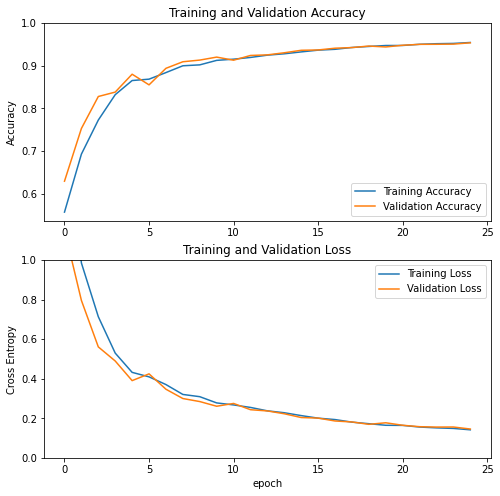

In [239]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [240]:
train_loss, train_accuracy = model.evaluate(train_generator, batch_size = 32)
validation_loss, validation_accuracy = model.evaluate(val_generator, batch_size = 32)
test_loss, test_accuracy = model.evaluate(test_generator, batch_size = 32)

2/2 [==============================] - 15s 3s/step - loss: 0.1388 - accuracy: 0.9571


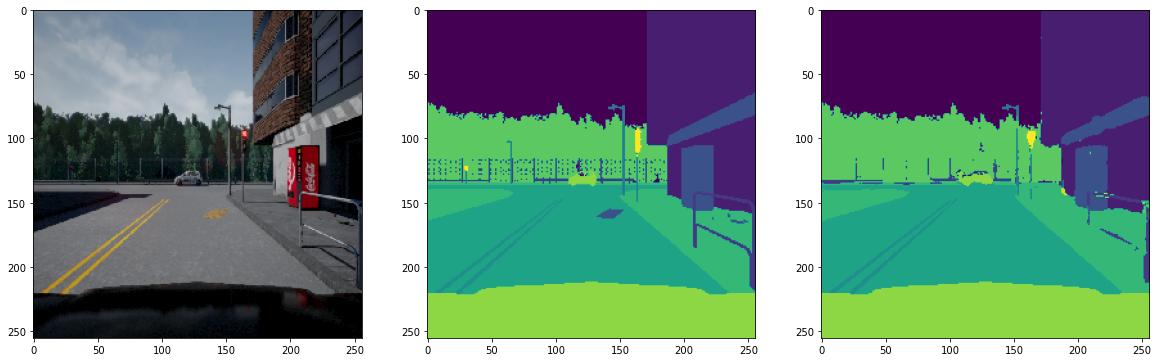

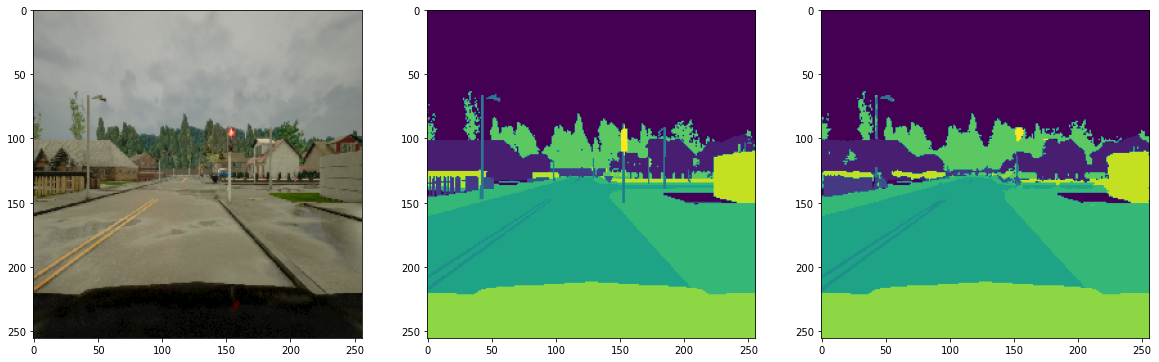

In [241]:
for image, mask in test_generator.take(6):
    pred_mask = model.predict(image)
    
    plt.figure(figsize=(20, 20))
    plt.subplot(1, 3, 1)
    plt.imshow(tf.keras.preprocessing.image.array_to_img(image[0]))
    plt.subplot(1, 3, 2)
    plt.imshow(tf.keras.preprocessing.image.array_to_img(mask[0]))
    plt.subplot(1, 3, 3)
    plt.imshow(tf.keras.preprocessing.image.array_to_img(tf.expand_dims(tf.argmax(pred_mask[0], axis = -1), axis = -1)))

In [247]:
def create_mask(dataset, model):
    true_masks, predicted_masks = [], []
    for images, masks in dataset:
        pred_masks = model.predict(images)
        pred_masks = tf.expand_dims(tf.argmax(pred_masks, axis=-1), axis=-1)
        true_masks.extend(masks)
        predicted_masks.extend(pred_masks)
        
    true_masks = np.array(true_masks)
    predicted_masks = np.array(predicted_masks)
        
    return true_masks, predicted_masks

In [248]:
true_train_masks, predicted_train_masks = create_mask(train_generator, model)
true_validation_masks, predicted_validation_masks = create_mask(val_generator, model)
true_test_masks, predicted_test_masks = create_mask(test_generator, model)

In [249]:
def evaluate_model(true_masks, predicted_masks, n_classes, smooth = 1e-6):
    
    """
    Evaluates semantic segmentation model
    
    Argument:
        true_masks: ground truth segmentations
        predicted_masks: predicted segmentations
        n_classes: number of segmentation classes
        smooth: a minute float digit added to denominators to avoid error from a zero division
    
    Returns:
        class_wise_evaluations: a dictionary containing evaluation metric 
                                outputs the for each segmentation class 
        overall_evaluations: a dictionary containing evaluation metric 
                             outputs the for all segmentation classes
        """
    # Create empty lists to store evaluation metric outputs
    class_wise_true_positives, class_wise_true_negatives = [],[]
    class_wise_false_positives, class_wise_false_negatives = [],[]
    class_wise_precisions, class_wise_recalls = [],[] 
    class_wise_specificities, class_wise_ious = [],[] 
    class_wise_tdrs, class_wise_f1_scores = [],[]
    classes = []
            
    for clas in range(n_classes):
        true_positives, true_negatives, false_positives, false_negatives = 0,0,0,0
        precisions, recalls, specificities, ious, f1_scores, tdrs = 0,0,0,0,0,0        
        
        number_of_masks = true_masks.shape[0]
        
        for mask_id in range(number_of_masks):
            true_positive = np.sum(np.logical_and(true_masks[mask_id]==clas, predicted_masks[mask_id]==clas))
            true_negative = np.sum(np.logical_and(true_masks[mask_id]!=clas, predicted_masks[mask_id]!=clas))
            false_positive = np.sum(np.logical_and(true_masks[mask_id]!=clas, predicted_masks[mask_id]==clas))
            false_negative = np.sum(np.logical_and(true_masks[mask_id]==clas, predicted_masks[mask_id]!=clas))
            
            true_positives += true_positive
            true_negatives += true_negative
            false_positives += false_positive
            false_negatives += false_negative

        recall = round(true_positives/(true_positives + false_negatives + smooth), 2)
        precision = round(true_positives/(true_positives + false_positives + smooth), 2)
        specificity = round(true_negatives/(true_negatives + false_positives + smooth), 2)
        tdr = round((1 - (false_negatives/(true_positives + false_negatives + smooth))), 2)
        iou = round(true_positives/(true_positives + false_negatives + false_positives + smooth), 2)
        f1_score = round((2 * precision * recall)/(precision + recall + smooth), 2)
        
        class_wise_true_positives.append(true_positives)
        class_wise_true_negatives.append(true_negatives)
        class_wise_false_positives.append(false_positives)
        class_wise_false_negatives.append(false_negatives)
        class_wise_recalls.append(recall)
        class_wise_precisions.append(precision)
        class_wise_specificities.append(specificity)
        class_wise_ious.append(iou)
        class_wise_tdrs.append(tdr)
        class_wise_f1_scores.append(f1_score)
        classes.append("Class " + str(clas+1))
        # class_wise_pixel_accuracies.append(pixel_accuracy)
        
    total_true_positives = np.sum(class_wise_true_positives)
    total_true_negatives = np.sum(class_wise_true_negatives)
    total_false_positives = np.sum(class_wise_false_positives)
    total_false_negatives = np.sum(class_wise_false_negatives)
    mean_recall = round(np.average(np.array(class_wise_recalls)), 2)
    mean_precision = round(np.average(np.array(class_wise_precisions)), 2)
    mean_specificity = round(np.average(np.array(class_wise_specificities)), 2)
    mean_iou = round(np.average(np.array(class_wise_ious)), 2)
    mean_tdr = round(np.average(np.array(class_wise_tdrs)), 2)
    mean_f1_score = round(np.average(np.array(class_wise_f1_scores)), 2)    
         
    class_wise_evaluations = {"Class": classes,
                              "True Positive Pixels": class_wise_true_positives,
                              "True Negative Pixels": class_wise_true_negatives,
                              "False Positive Pixels": class_wise_false_positives,
                              "False Negative Pixels": class_wise_false_negatives,
                              "Recall": class_wise_recalls,
                              "Precision": class_wise_precisions,
                              "Specificity": class_wise_specificities,
                              "IoU": class_wise_ious,
                              "TDR": class_wise_tdrs,
                              "F1-Score": class_wise_f1_scores}

    overall_evaluations = {"Class": "All Classes",
                        "True Positive Pixels": total_true_positives,
                        "True Negative Pixels": total_true_negatives,
                        "False Positive Pixels": total_false_positives,
                        "False Negative Pixels": total_false_negatives,
                        "Recall": mean_recall,
                        "Precision": mean_precision,
                        "Specificity": mean_specificity,
                        "IoU": mean_iou,
                        "TDR": mean_tdr,
                        "F1-Score": mean_f1_score}
    
    evaluations = {"Overall Evaluations": overall_evaluations, 
                   "Class-wise Evaluations": class_wise_evaluations}
    
    return evaluations

In [250]:
def show_evaluations(evaluations, 
                     metrics=["Recall", "Precision", "Specificity", "IoU", "TDR", "F1 Score"], 
                     class_list=None,
                     display_evaluations="All"):
    """
    Returns a pandas dataframe containing specified metrics
        
        Arguments:
            evaluations: evaluation output from the evaluate_model function
            metrics: a list containing one or more of the following metrics:
                     'True Positive', 'True Negative', 'False Positive', 'False Negative',
                     'Recall', 'Precision', 'Specificity', 'F1 Score', 'IoU', 'TDR'
            display_evaluations: one of 'All' to display both overall and class-wise evaluations,
                                 'Overall' to display only the overall evaluations,
                                 'Class-wise' to display only the classwise evaluations.
            class_list: list or tuple containing names of segmentation class.
    """
    
    # Split evaluations into overall and class-wise evaluations
    overall_evaluations = evaluations["Overall Evaluations"]
    class_wise_evaluations = evaluations["Class-wise Evaluations"]
    
    # Validate list of metrics 
    for metric_id in range(len(metrics)):
        metric = metrics[metric_id]
        if metric not in overall_evaluations:
            raise ValueError("'metrics argument' not properly defined. "
                            "Kindly create a list containing one or more of the following metrics: "
                             "'True Positive', 'True Negative', 'False Positive', 'False Negative', "
                             "'Recall', 'Precision', 'Specificity', 'F1 Score', 'IoU', 'TDR'") 
    
    # Check if class_list is none
    if class_list != None and all(isinstance(class_, str) for class_ in class_list):
        if len(class_list) == len(class_wise_evaluations["Class"]):
            class_list = [class_list]
        else:
            raise ValueError("class_list argument' not properly defined. " 
                             "List is either shorter or longer than segmentation classes") 
    else:
        class_list = [class_wise_evaluations["Class"]]                             
    
    # Extract data from the evaluations
    overall_data = [overall_evaluations["Class"]] + [overall_evaluations[metrics[metric_id]] for metric_id in range(len(metrics))]
    classwise_data = class_list + [class_wise_evaluations[metrics[metric_id]] for metric_id in range(len(metrics))]
    overall_data = np.array(overall_data).reshape(1,-1)
    classwise_data = np.array(classwise_data).transpose()
    
    # Determine the type of evaluation report to display
    if display_evaluations.lower() == "all":
        data = np.concatenate((overall_data, classwise_data), axis=0)
    elif display_evaluations.lower() == "overall":
        data = overall_data
    elif display_evaluations.lower() == "class-wise" or "classwise":
        data = classwise_data
    else:
        raise ValueError("Display argument are not properly defined."
                        "Kindly use 'All' to display both overall and class-wise evaluations."
                        "Use 'Overall' to display only the overall evaluations."
                        "Or use 'Class-wise' to display only the class-wise evaluations")

    
    # Create evaluation report as a pandas dataframe
    dataframe = pd.DataFrame(data)
    dataframe_titles = ["Class"] + metrics
    dataframe.columns = dataframe_titles
    # dataframe = dataframe.set_index(dataframe_titles[0], col_level=1)
    
    return dataframe

In [251]:
model_evaluation_on_train_dataset = evaluate_model(true_train_masks, predicted_train_masks, n_classes=13)

show_evaluations(model_evaluation_on_train_dataset, 
                 metrics=["Recall", "Precision", "Specificity", "IoU", "TDR", "F1-Score"], 
                 class_list=None, 
                 display_evaluations="All")

,Class,Recall,Precision,Specificity,IoU,TDR,F1-Score
0,All Classes,0.69,0.78,1.0,0.64,0.69,0.72
1,Class 1,0.98,0.98,0.99,0.97,0.98,0.98
2,Class 2,0.94,0.91,0.99,0.86,0.94,0.92
3,Class 3,0.58,0.7,1.0,0.47,0.58,0.63
4,Class 4,0.42,0.71,1.0,0.36,0.42,0.53
5,Class 5,0.0,0.0,1.0,0.0,0.0,0.0
6,Class 6,0.29,0.73,1.0,0.26,0.29,0.42
7,Class 7,0.85,0.89,1.0,0.77,0.85,0.87
8,Class 8,0.98,0.99,1.0,0.97,0.98,0.98
9,Class 9,0.96,0.93,0.99,0.89,0.96,0.94


In [254]:
y_true = true_train_masks
y_pred = predicted_train_masks

In [255]:
# one hot encoding of predictions
num_classes = y_pred.shape[-1]
y_pred = np.array([ np.argmax(y_pred, axis=-1)==i for i in range(num_classes) ]).transpose(1,2,3,0)

axes = (1,2) # W,H axes of each image
intersection = np.sum(np.logical_and(y_pred, y_true), axis=axes)
# intersection = np.sum(np.abs(y_pred * y_true), axis=axes)
union = np.sum(np.logical_or(y_pred, y_true), axis=axes)
mask_sum = np.sum(np.abs(y_true), axis=axes) + np.sum(np.abs(y_pred), axis=axes)
# union = mask_sum  - intersection

smooth = .001
iou = (intersection + smooth) / (union + smooth)
dice = 2 * (intersection + smooth)/(mask_sum + smooth)

iou = np.mean(iou)
dice = np.mean(dice)

In [256]:
iou

0.689207272503551

In [259]:
%config InlineBackend.figure_format = "svg"

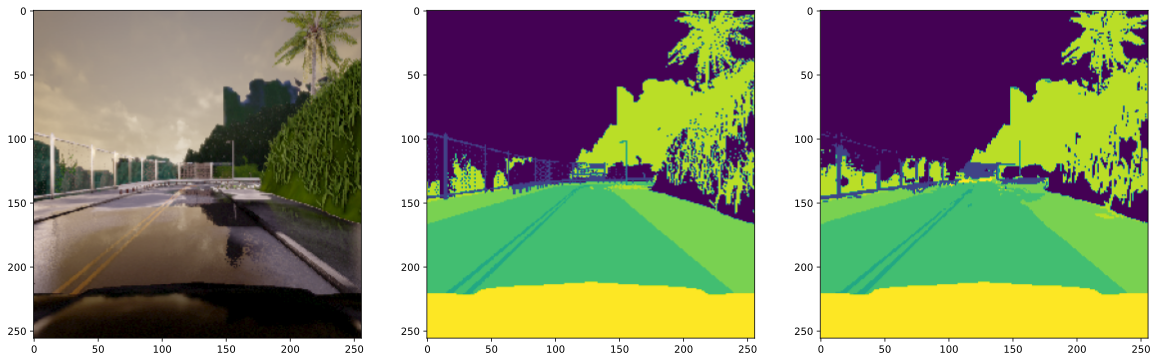

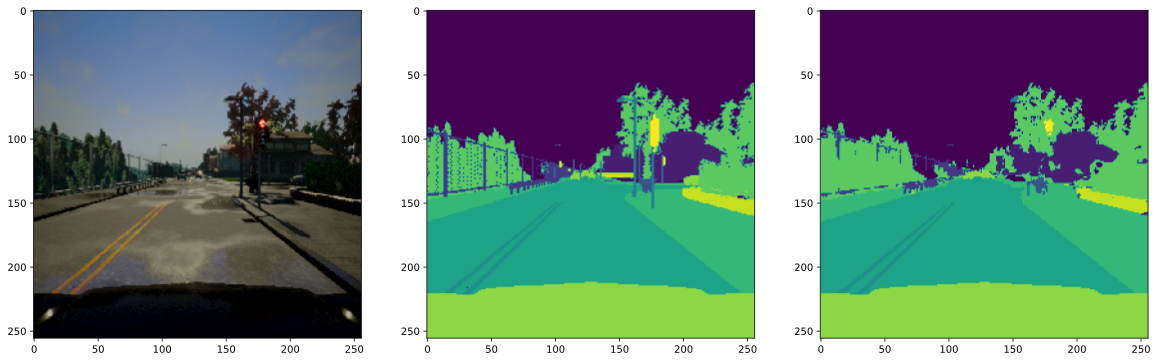

In [272]:
for image, mask in test_generator.take(6):
    pred_mask = model.predict(image)
    
    plt.figure(figsize=(20, 20))
    plt.subplot(1, 3, 1)
    plt.imshow(tf.keras.preprocessing.image.array_to_img(image[0]))
    plt.subplot(1, 3, 2)
    plt.imshow(tf.keras.preprocessing.image.array_to_img(mask[0]))
    plt.subplot(1, 3, 3)
    plt.imshow(tf.keras.preprocessing.image.array_to_img(tf.expand_dims(tf.argmax(pred_mask[0], axis = -1), axis = -1)))

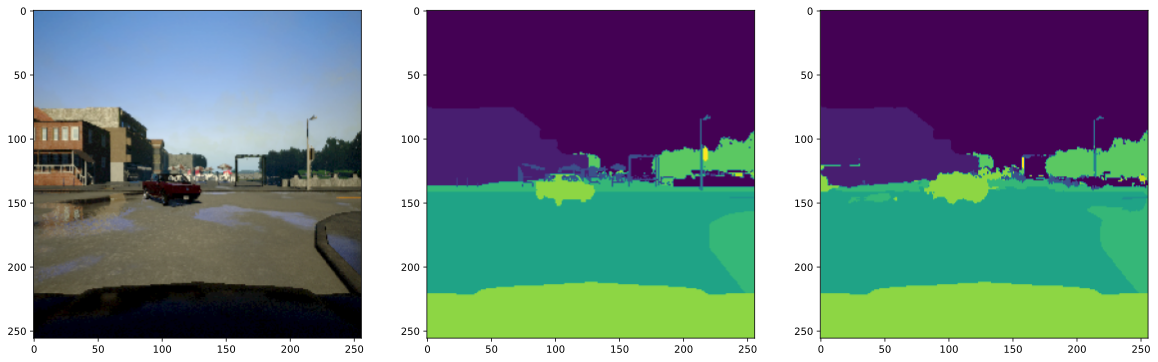

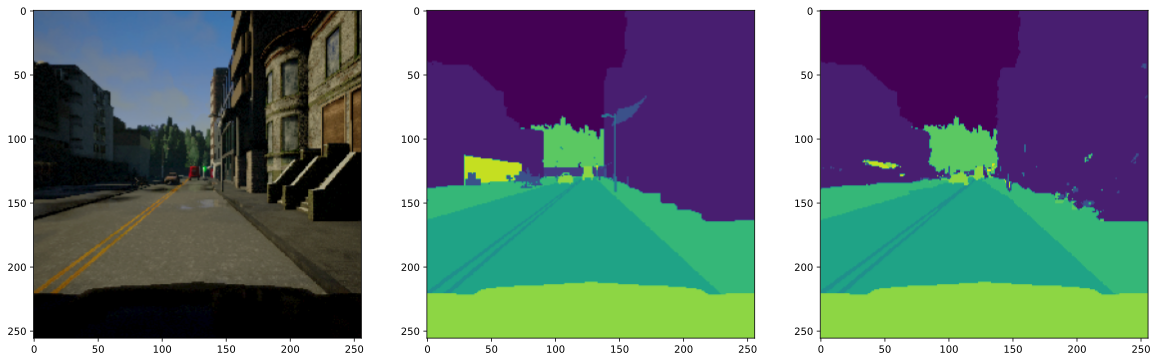

In [271]:
for image, mask in test_generator.take(6):
    pred_mask = model.predict(image)
    
    plt.figure(figsize=(20, 20))
    plt.subplot(1, 3, 1)
    plt.imshow(tf.keras.preprocessing.image.array_to_img(image[0]))
    plt.subplot(1, 3, 2)
    plt.imshow(tf.keras.preprocessing.image.array_to_img(mask[0]))
    plt.subplot(1, 3, 3)
    plt.imshow(tf.keras.preprocessing.image.array_to_img(tf.expand_dims(tf.argmax(pred_mask[0], axis = -1), axis = -1)))

In [276]:
y_true = true_validation_masks
y_pred = predicted_validation_masks

In [ ]:
true_validation_masks, predicted_validation_masks = create_mask(val_generator, model)



In [277]:
# one hot encoding of predictions
num_classes = y_pred.shape[-1]
y_pred = np.array([ np.argmax(y_pred, axis=-1)==i for i in range(num_classes) ]).transpose(1,2,3,0)

axes = (1,2) # W,H axes of each image
intersection = np.sum(np.logical_and(y_pred, y_true), axis=axes)
# intersection = np.sum(np.abs(y_pred * y_true), axis=axes)
union = np.sum(np.logical_or(y_pred, y_true), axis=axes)
mask_sum = np.sum(np.abs(y_true), axis=axes) + np.sum(np.abs(y_pred), axis=axes)
# union = mask_sum  - intersection

smooth = .001
iou = (intersection + smooth) / (union + smooth)
dice = 2 * (intersection + smooth)/(mask_sum + smooth)

iou = np.mean(iou)
dice = np.mean(dice)

In [278]:
iou

0.6866683054097242